<a href="https://colab.research.google.com/github/JackPerry0/DeterminantCalculator/blob/main/DeterminantBackPropogationCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
import graphviz
%matplotlib inline

In [15]:
class Value:
  def __init__(self, matrix, _children =(), _op='', _det=0, history = ()):
    self.matrix = self.convert_matrix_to_doubles(matrix) #this is a matrix of the form [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]] in other words an array of array's
    self._det = _det
    self.history = history

  def __repr__(self):
    #Return a string that represents the matrix.
    s = "{ "
    for row in self.matrix:
      s += '[ '
      for element in row:
          s += str(element) + ' '
      s += '] '
    s += "}"
    return s

  def __mul__(self, other):

    # Check if 'other' is a Value object. If not, assume it's a list and create a Value object from it.
    if not isinstance(other, Value):
      other = Value(other)

    #reorder the matrices so that the order of multiplication is correct.
    #I didnt originally account for this so this code is the result of fixing this without redoing some of the logic written below.
    temp = self.matrix
    self.matrix = other.matrix
    other.matrix = temp



    newMatrix = []

    for rIndex in range(len(self.matrix)):
      newRow = []
      selfRow = self.getColAtIndex(rIndex)

      for rIndexOfOther in range(len(other.matrix)):
        otherRow = other.matrix[rIndexOfOther]
        newRow.append(sum(ij * otherij for ij, otherij in zip(selfRow, otherRow)))

      newMatrix.append(newRow)


    newMatrix = self.transpose(newMatrix)

    temp = self.matrix
    self.matrix = other.matrix
    other.matrix = temp

    return Value(newMatrix, (self, other), '*')

  def getColAtIndex(self, rIndex):
      selfRow = []
      for row in self.matrix:
        for index, element in enumerate(row):
          if index == rIndex:
            selfRow.append(element)

      return selfRow

  def transpose(self, newMatrix):
    transposeMatrix = []

    for i in range(len(newMatrix[0])):
      transposeRow = []
      for row in newMatrix:
        transposeRow.append(row[i])
      transposeMatrix.append(transposeRow)

    return transposeMatrix

  def forwardPass(self):
    step = 1
    detSign = 1

    history = [(copy.deepcopy(self.matrix), "original Matrix", "step = " + str(step), "determinant = " + str(detSign), detSign)]
    step += 1

    Matrix = Value(self.matrix)

    for rIndex in range(len(Matrix.matrix)):
    #Ensure there is a pivot value of non zero when i == j.
      swapIndex = Matrix.findRowIndexWithNonZeroEntryInCol(Matrix.matrix, rIndex)
      if swapIndex == rIndex:
        detSign *= 1
        history.append((copy.deepcopy(Matrix.matrix), "we did not swap row " + str(rIndex + 1), "step = " + str(step), "determinant = " + str(detSign), detSign))
        step += 1
      else:
        detSign *= -1
        Matrix = Matrix.swapRows(rIndex, swapIndex, len(Matrix.matrix))
        history.append((copy.deepcopy(Matrix.matrix), "swaped row " + str(rIndex + 1) + " with row " + str(swapIndex + 1), "step = " + str(step), "determinant = " + str(detSign), detSign))  #adding each matrix modification
        step += 1

    #remove elements below the pivot
      for subRowIndex in range( rIndex + 1, len(Matrix.matrix)):
        subRow = Matrix.matrix[subRowIndex]
        multiplier = -1 * (subRow[rIndex] / Matrix.matrix[rIndex][rIndex])
        history.append((copy.deepcopy(Matrix.matrix), " adding a " + str(multiplier) + " scalar multiple of row " + str(rIndex + 1) + " to row " + str(subRowIndex + 1), "step = " + str(step), "determinant = " + str(detSign), detSign))

        Matrix.matrix = self.addingAScalerMultiple(Matrix.matrix, rIndex, subRowIndex, multiplier)
        history.append((copy.deepcopy(Matrix.matrix), " Resulting Matrix ", "step = " + str(step), "determinant = " + str(detSign), detSign))
        step += 1


    Matrix._det = detSign * Matrix.getDeterminant()
    Matrix.history = history
    return Matrix


  def addingAScalerMultiple(self, matrix, rIndex, subRowIndex, multiplier):
    multipliedRow = [element * multiplier for element in matrix[rIndex]]
    matrix[subRowIndex] = [x + y for x, y in zip(multipliedRow, matrix[subRowIndex])]
    return matrix


  def findRowIndexWithNonZeroEntryInCol(self, matrix, cIndex):
    #Finds the index of the row that the row should be swapped with in order to have a pivot in each diagonal entry.
    for rIndex, row in enumerate(matrix, start=cIndex):
      if row[cIndex] != 0:
        return rIndex

  def swapRows(self, rIndex, swapIndex, n):
    #create identity matrix of size n
    identityMatrix = []

    for i in range(n):
      identityRow = []
      for j in range(n):
        if i == j:
          identityRow.append(1)
        else:
          identityRow.append(0)
      identityMatrix.append(identityRow)

    #swap row at index rIndex and swapIndex
    elementaryMatrix = identityMatrix
    temp = elementaryMatrix[rIndex]
    elementaryMatrix[rIndex] = elementaryMatrix[swapIndex]
    elementaryMatrix[swapIndex] = temp


    #Transform the matrix by the elementaryMatrix

    transformedMatrix = Value(elementaryMatrix) * self.matrix

    return transformedMatrix

  #this is a helper function - to find the determinant use .forwardPass()
  def getDeterminant(self):
    det = 1
    for index, row in enumerate(self.matrix):
      det *= row[index]
    return det

  def format_matrix(self, m):
    return '\n'.join(['[ ' + ', '.join(str(elem) for elem in row) + ' ]' for row in m])

  def convert_matrix_to_doubles(self, matrix):
    return [[float(elem) for elem in row] for row in matrix]

  def draw_dot(self):
    dot = graphviz.Digraph()
    dot.attr(rankdir='LR')  # Horizontal layout (left to right)

    for i in range(len(self.history)):
        matrix_str = self.format_matrix(self.history[i][0]).replace('\n', '<BR/>')
        description = self.history[i][1]
        step = self.history[i][2]
        determinant = self.history[i][3]

        # HTML table with 3 rows for matrix, description, and step
        label = f"""<
        <TABLE BORDER="1" CELLBORDER="1" CELLSPACING="1" CELLPADDING="4">
            <TR><TD>{matrix_str}</TD></TR>
            <TR><TD>{determinant}</TD></TR>
            <TR><TD>{description}</TD></TR>
            <TR><TD>{step}</TD></TR>
        </TABLE>
        >"""

        dot.node(str(i), label, shape="none")

    for i in range(len(self.history) - 1):
        dot.edge(str(i), str(i + 1))


    #now we multiply the diagonal

    label = str(self.history[len(self.history)-1][4]) + " * "

    for i in range(len(self.matrix)):
      if i != len(self.matrix) - 1:
        label += str(self.matrix[i][i]) + " * "
      else:
        label += str(self.matrix[i][i])

    dot.node(str(len(self.history)), label, shape="box")

    dot.edge(str(len(self.history) - 1), str(len(self.history)))

    dot.node(str(len(self.history) + 1), str(self._det), shape="box")

    dot.edge(str(len(self.history)), str(len(self.history) + 1))

    return dot





In [16]:
#print(x.matrix, "matrix")
#print(y.matrix)
#print(y.getDeterminant())
#print(y._det)

x = Value([[1,2,3],[4,5,6],[7,8,10]])

y = x.forwardPass()

print("Upper triangular matrix ", y.matrix)

print("Resulting Determinant", y._det)

print("history of all the steps ", y.history)

Upper triangular matrix  [[1.0, 2.0, 3.0], [0.0, -3.0, -6.0], [0.0, 0.0, 1.0]]
Resulting Determinant -3.0
history of all the steps  [([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 10.0]], 'original Matrix', 'step = 1', 'determinant = 1', 1), ([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 10.0]], 'we did not swap row 1', 'step = 2', 'determinant = 1', 1), ([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 10.0]], ' adding a -4.0 scalar multiple of row 1 to row 2', 'step = 3', 'determinant = 1', 1), ([[1.0, 2.0, 3.0], [0.0, -3.0, -6.0], [7.0, 8.0, 10.0]], ' Resulting Matrix ', 'step = 3', 'determinant = 1', 1), ([[1.0, 2.0, 3.0], [0.0, -3.0, -6.0], [7.0, 8.0, 10.0]], ' adding a -7.0 scalar multiple of row 1 to row 3', 'step = 4', 'determinant = 1', 1), ([[1.0, 2.0, 3.0], [0.0, -3.0, -6.0], [0.0, -6.0, -11.0]], ' Resulting Matrix ', 'step = 4', 'determinant = 1', 1), ([[1.0, 2.0, 3.0], [0.0, -3.0, -6.0], [0.0, -6.0, -11.0]], 'we did not swap row 2', 'step = 5', 'determinant = 1', 1), ([[1.0, 

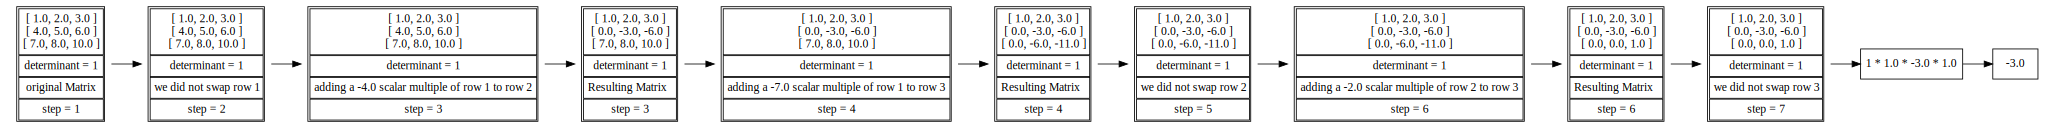

In [17]:
from IPython.display import display

dot = y.draw_dot()

display(dot)

Other use cases

In [18]:
x = Value([[1,2,3],[4,5,6],[7,8,9]])
x

{ [ 1.0 2.0 3.0 ] [ 4.0 5.0 6.0 ] [ 7.0 8.0 9.0 ] }

Swapping rows 1 and 3

In [19]:
x = Value([[1,2,3],[4,5,6],[7,8,9]])
y = Value([[0,0,1],[0,1,0],[1,0,0]])

z = y * x
print(z)

{ [ 7.0 8.0 9.0 ] [ 4.0 5.0 6.0 ] [ 1.0 2.0 3.0 ] }


Scaling row 1 by 3

In [20]:
x = Value([[1,2,3],[4,5,6],[7,8,9]])
y = Value([[3,0,0],[0,1,0],[0,0,1]])
z = y * x
print(z)

{ [ 3.0 6.0 9.0 ] [ 4.0 5.0 6.0 ] [ 7.0 8.0 9.0 ] }


Adding 2*row 3 to row 1.

In [21]:
x = Value([[1,2,3],[4,5,6],[7,8,9]])
y = Value([[1,0,2],[0,1,0],[0,0,1]])
z = y * x
print(z)

{ [ 15.0 18.0 21.0 ] [ 4.0 5.0 6.0 ] [ 7.0 8.0 9.0 ] }


In [22]:
P = Value([[-1,0],[-1,1]])
C = Value([[1,-1],[1,1]])
A = Value([[0,1],[-2,2]])

In [23]:
z = A*P
z

{ [ -1.0 1.0 ] [ 0.0 2.0 ] }